# Using Autoencoder architecture to create latent representation of 1024 time domain scans

## Proposed Approaches
1. Classic Classification on encoder-decoder latent vector  
- Train encoder-decoder on reconstruction task  
- Train FCNN to classify the pulses  
- Train CNN based Auto-encoder and vizualize latent space

2. Hybrid network approach  
- Multi-headed network to produce latent space and classify from the latent space  
- Creates a classification focussed embedding  
- Joint loss function (will need loss contributions to be tuned)  

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset
from models.Encoder_decoder import Autoencoder, CNNAutoencoder, train_autoencoder
from models.utils import identify_device, load_thz_dataset
from Simulate import simulate_reference

from models.encoder_decoder_utils import plot_latent_space_with_labels, test_model


# Load THz pulse dataset (assumes each sample is a 1D tensor of size 1024)
data = torch.load("Synthetic_data_60k.pt", weights_only=False)
synthetic_data = data["synthetic_data"]  # [N, 1024]
num_layers = data["num_layers"]

synthetic_data.shape

torch.Size([60000, 1024])

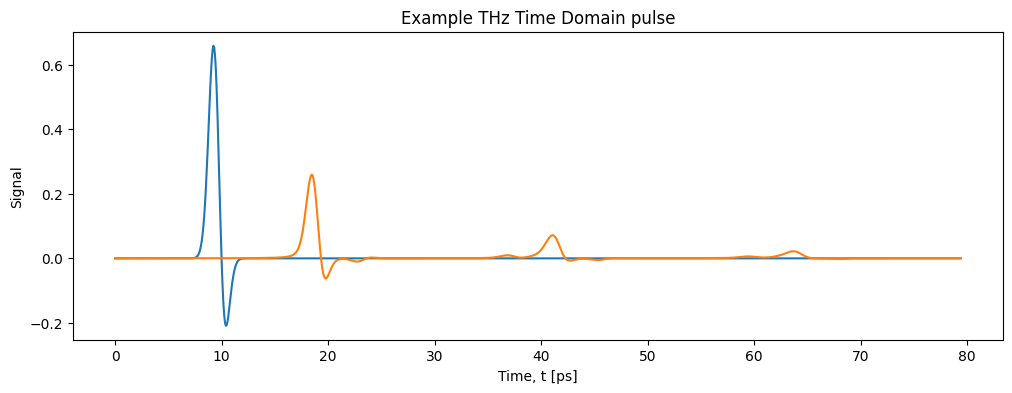

In [2]:
deltat = 0.0194e-12 * 4 # 4x multiple from the downsampling during dataset production
L = synthetic_data.shape[1]
t_axis = np.arange(0, L*deltat, deltat)


ref_pulse = simulate_reference(L=4*L, deltat=deltat)[:L].detach().cpu().numpy()

plt.figure(figsize=(12,4))
plt.title('Example THz Time Domain pulse')
plt.plot(t_axis*1e12, ref_pulse)
plt.plot(t_axis*1e12, synthetic_data[0])
plt.ylabel('Signal')
plt.xlabel('Time, t [ps]')
plt.show()

## FCNN Auto-encoder

In [3]:
model_summary_FCAE = Autoencoder()#.to(device=identify_device())
summary(model_summary_FCAE, input_size=(1, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         524,800
              ReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 128]          65,664
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 32]           4,128
         FCEncoder-6                [-1, 1, 32]               0
            Linear-7               [-1, 1, 128]           4,224
              ReLU-8               [-1, 1, 128]               0
            Linear-9               [-1, 1, 512]          66,048
             ReLU-10               [-1, 1, 512]               0
           Linear-11              [-1, 1, 1024]         525,312
        FCDecoder-12              [-1, 1, 1024]               0
Total params: 1,190,176
Trainable params: 1,190,176
Non-trainable params: 0
---------------------------

Using device: mps


Training epochs: 100%|██████████| 50/50 [03:03<00:00,  3.66s/epoch]


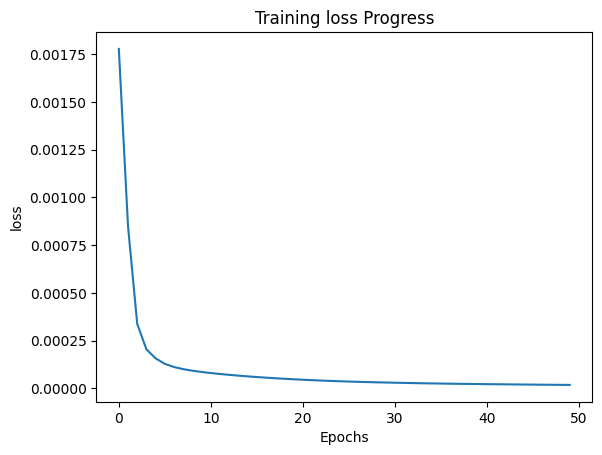

In [4]:
# Create DataLoader
dataset = TensorDataset(synthetic_data)
FCAE_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model + training
model = Autoencoder(input_dim=1024, latent_dim=32)
device = identify_device()
loss = train_autoencoder(model, FCAE_loader, device, num_epochs=50, lr=1e-5, verbose='epoch')


# Plot the accuracy values
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training loss Progress')
plt.show()

Sample Index: 34690
Loss between signals: 7.402077699225629e-06


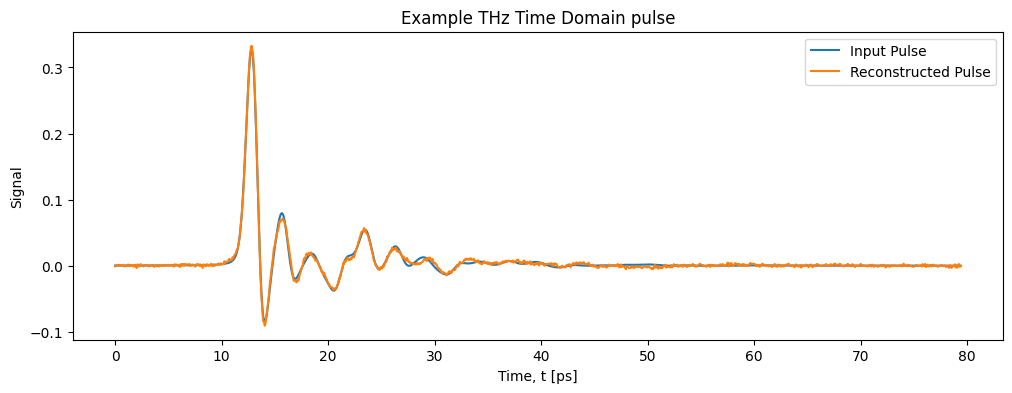

In [5]:
sample_index = np.random.randint(0, len(synthetic_data))

print(f'Sample Index: {sample_index}')


test_model(sample_index, model, device=device, time_pulses=synthetic_data, deltat=deltat)

Loss between signals: 6.8186032876838e-05


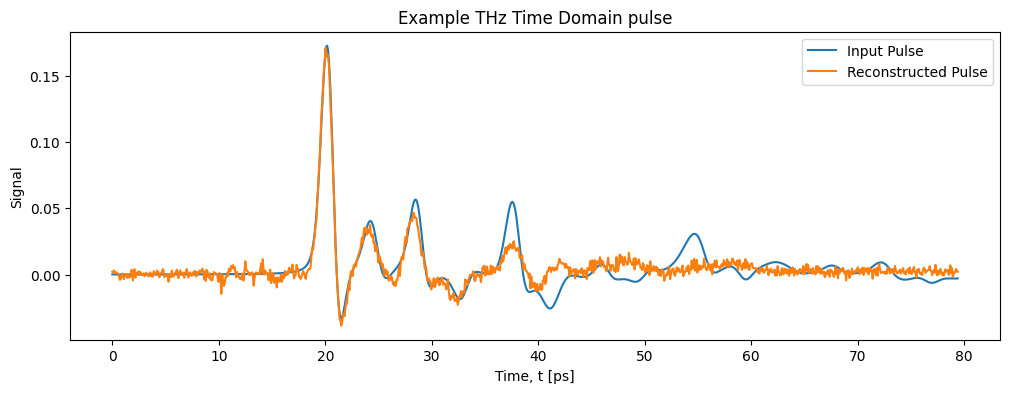

In [6]:
## NOTE: sample index: 41212  needs checking
# Example of weak loss contributor due to low overall amplitude

test_model(41212, model)

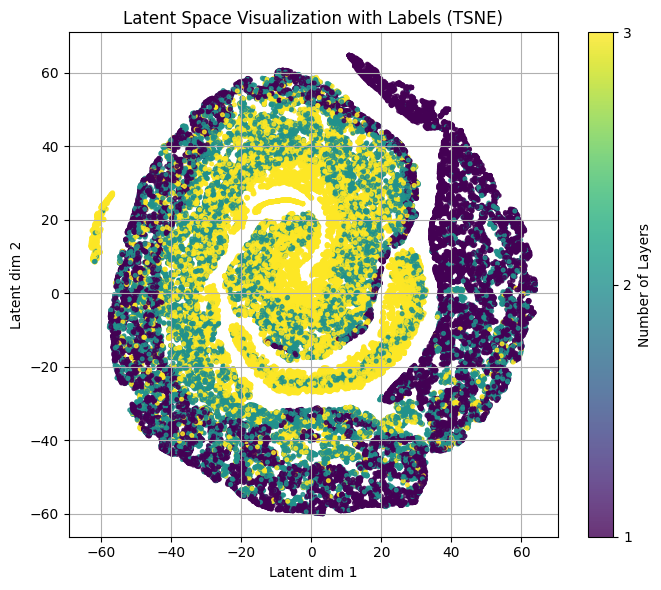

In [7]:
plot_latent_space_with_labels(model, synthetic_data, num_layers, device, 'tsne', 60000)

## CNN Auto-encoder

In [8]:
device = identify_device()
model_summary_CAE = CNNAutoencoder()#.to(device)
summary(model_summary_CAE, input_size=(1, 1024))

Using device: mps
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 512]              80
              ReLU-2              [-1, 16, 512]               0
            Conv1d-3              [-1, 32, 256]           2,080
              ReLU-4              [-1, 32, 256]               0
            Conv1d-5              [-1, 64, 128]           8,256
              ReLU-6              [-1, 64, 128]               0
           Flatten-7                 [-1, 8192]               0
            Linear-8                   [-1, 32]         262,176
        CNNEncoder-9                   [-1, 32]               0
           Linear-10                 [-1, 8192]         270,336
        Unflatten-11              [-1, 64, 128]               0
  ConvTranspose1d-12              [-1, 32, 256]           8,224
             ReLU-13              [-1, 32, 256]               0
  ConvTranspose1d-14 

In [9]:
CNN_dataset = TensorDataset(synthetic_data.unsqueeze(1))
CNN_loader = DataLoader(CNN_dataset, batch_size=64, shuffle=True)


model_CNNAE = CNNAutoencoder(input_dim=1024, latent_dim=32)
model_CNNAE.to(device)
loss = train_autoencoder(model_CNNAE, CNN_loader, device, num_epochs=50, lr=1e-5, verbose='epoch')

Training epochs: 100%|██████████| 50/50 [03:54<00:00,  4.68s/epoch]


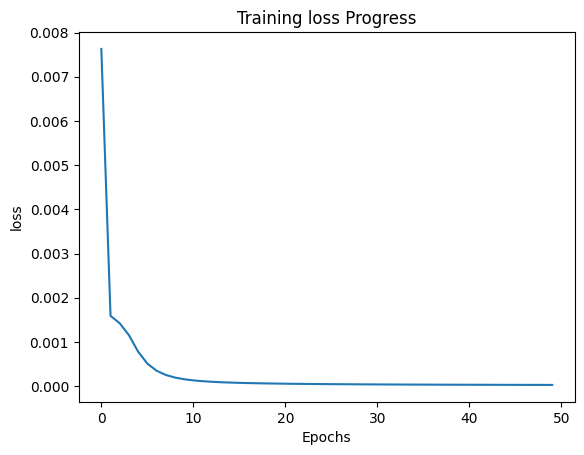

In [10]:
# Plot the accuracy values
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training loss Progress')
plt.show()

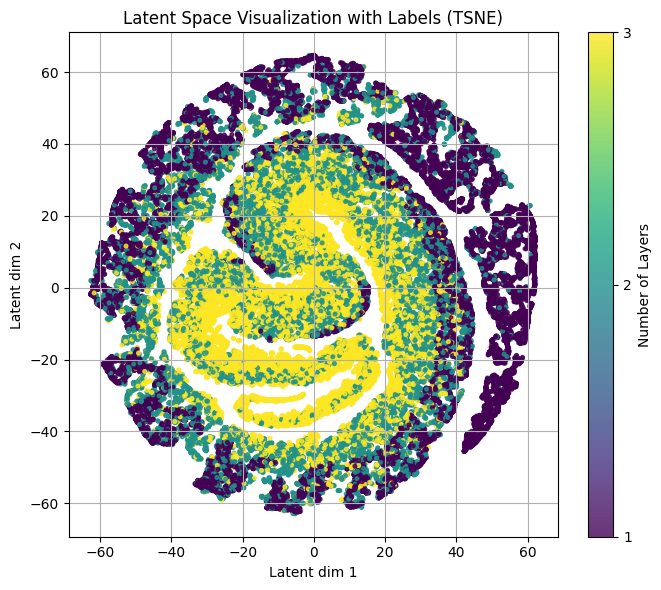

In [11]:
plot_latent_space_with_labels(model_CNNAE, synthetic_data.unsqueeze(1), num_layers, device, 'tsne', 60000)

## Variational Auto-Encoder method